# Critical Hit Rate

Consider a game where each attack has a probability of $p$ to be a critical hit. How many critical hit will be performed when attacking $N$ times?

If we use an algorithm that each attack is independent from each other, the result will be a binomial distribution.

[0.011529215046068483, 0.05764607523034241, 0.13690942867206324, 0.20536414300809488, 0.21819940194610077, 0.17455952155688062, 0.1090997009730504, 0.05454985048652519, 0.022160876760150862, 0.007386958920050287, 0.0020314137030138287, 0.0004616849325031429, 8.656592484433929e-05, 1.3317834591436814e-05, 1.6647293239296018e-06, 1.6647293239296019e-07, 1.3005697843200014e-08, 7.65041049600001e-10, 3.187671040000004e-11, 8.388608000000009e-13, 1.0485760000000012e-14]
E[X] = 4.0, sigma[X] = 1.7888543819998317
E[X] = 4.000000000000005, sigma[X] = 1.7888543819998328


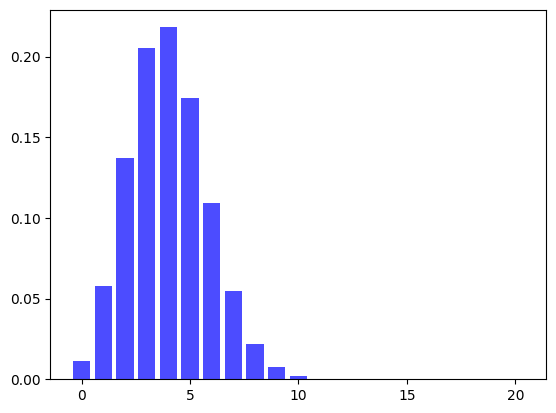

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math

N = 20
p = 0.2

def binomial_distribution(n, p):
    return [math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k)) for k in range(n + 1)]

x = np.arange(0, N + 1)
y = binomial_distribution(N, p)
plt.bar(x, y, color='blue', alpha=0.7)

print(y)
print(f'E[X] = {N * p}, sigma[X] = {math.sqrt(N * p * (1 - p))}')
print(f'E[X] = {np.sum(x * y)}, sigma[X] = {math.sqrt(np.sum((x - np.sum(x * y)) ** 2 * y))}')

The variance of the result of this algorithm is too high. A player can get no critical hit for many attacks, which is very annoying.

If we use a better algorithm, we can ensure a critical hit in limited attacks, while maintaining the specified critical hit rate. We can use a method called PRD:

- Starting from a critical hit rate of $q$ instead of specified $p$ (usually $q < p$);
- If there is no critical hit for continuous $n$ attacks, the next attack will have a critical hit rate of $p(n)=(n+1)q$;
- If any critical hit is performed, reset the hit rate to $q$.

This is a random process called Markov Chain. It has $\lceil \frac{1}{q} \rceil$ states. For example, let $q=0.3$, then there are $4$ states, and the transition matrix can be written as:
$$
\mathbf P=\left[
\begin{array}{cccc}
0.3 & 0.7 & 0 & 0 \\
0.6 & 0 & 0.4 & 0 \\
0.9 & 0 & 0 & 0.1 \\
1 & 0 & 0 & 0
\end{array}
\right]
$$
where each element $\mathbf P_{ij}$ is the probability of state $i$ to state $j$:
$$\mathbf P_{ij}=\Pr(X_{n+1}=j|X_n=i)$$

The stationary distribution $\mathbf \pi$ must satisfy:
$$
\mathbf \pi \mathbf P = \mathbf \pi
$$
Therefore, $\mathbf \pi$ is the eigenvector of $\mathbf P$ with eigenvalue $1$。 Also the elements of $\mathbf \pi$ must sum up to $1$. In practice, we can solve the following linear equations:
$$
\left[
\begin{array}{c}
\mathbf P^T - \mathbf I \\
\mathbf 1
\end{array}
\right] \, \mathbf \pi = \left[
\begin{array}{c}
\mathbf 0\\
1
\end{array}
\right]
$$

Then we can find out the average critical hit rate:
$$
\begin{aligned}
p&=\sum \mathbf \pi_n \min(nq,1) \\
&=\left[
\begin{array}{cccc}
0.498 & 0.349 & 0.139 & 0.014
\end{array}
\right]
\left[
\begin{array}{c}
0.3\\
0.6\\
0.9\\
1
\end{array}
\right] \\
& \approx 0.498
\end{aligned}
$$

Therefore, when $q=0.3$, the average critical hit rate is approximately 50%.

We can precalculate a $q$ for specified $p$. For example, for a critical hit rate of 20%, we can use $q=0.0557$.

In [2]:
def PRD(q):
    n_states = math.ceil(1 / q)
    P = np.zeros((n_states, n_states))
    for i in range(n_states - 1):
        P[i, 0] = (i + 1) * q
        P[i, i + 1] = 1 - (i + 1) * q
    P[n_states - 1, 0] = 1

    A = np.append(np.transpose(P) - np.eye(n_states), np.ones((1, n_states)), axis=0)
    b = np.append(np.zeros(n_states), 1)
    x = np.linalg.solve(np.transpose(A) @ A, np.transpose(A) @ b)

    return x

q = 0.0557
prd_stationary = PRD(q)
prd_pn = [q * (i + 1) for i in range(len(prd_stationary) - 1)] + [1]
print(f'PRD stationary distributon (q={q}) = {prd_stationary}')
print(f'p(n) = {prd_pn}')
p = sum([prd_stationary[i] * prd_pn[i] for i in range(len(prd_stationary))])
print(f'p = {p}')
print(f'E[X] = {np.sum(prd_stationary * prd_pn)}, sigma[X] = {math.sqrt(np.sum((prd_stationary - np.sum(prd_stationary * prd_pn)) ** 2 * prd_pn))}')

PRD stationary distributon (q=0.0557) = [1.99992323e-01 1.88852750e-01 1.67814554e-01 1.39772742e-01
 1.08631375e-01 7.83775372e-02 5.21837642e-02 3.18373146e-02
 1.76506072e-02 8.80235781e-03 3.89944451e-03 1.51025486e-03
 5.00800511e-04 1.38170861e-04 3.04252236e-05 5.00494928e-06
 5.44538482e-07 2.89149934e-08]
p(n) = [0.0557, 0.1114, 0.1671, 0.2228, 0.27849999999999997, 0.3342, 0.3899, 0.4456, 0.5013, 0.5569999999999999, 0.6127, 0.6684, 0.7241, 0.7798, 0.8355, 0.8912, 0.9469, 1]
p = 0.19999232285829385
E[X] = 0.19999232285829383, sigma[X] = 0.5684924825588308


Therefore, when $q=0.0557$, the average critical hit will be 20%. And there must be at least one critical hit when attacking for continuous 19 attacks.

We can use a DFS algorithm to find out how many critical hit will be performed when attacking $N$ times.

[0.00000000e+00 8.71482980e-04 5.45521385e-02 2.76311123e-01
 3.74925127e-01 2.14326724e-01 6.52655212e-02 1.21188652e-02
 1.49198355e-03 1.28599330e-04 8.04720657e-06 3.74456886e-07
 1.31511041e-08 3.51159212e-10 7.13070918e-12 1.09300903e-13
 1.24321168e-15 1.01682543e-17 5.65200393e-20 1.91117486e-22
 2.96662077e-25]
E[X] = 3.9998464571658796, sigma[X] = 1.0555648890412965


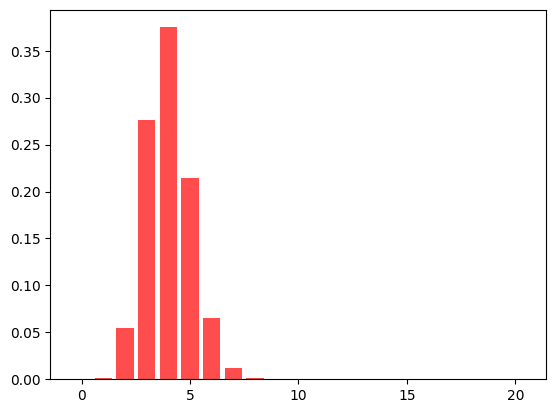

In [3]:
def PRD_N(q, N):
    prd_final = PRD(q)
    prd_p = [q * (i + 1) for i in range(len(prd_final) - 1)] + [1]
    prd_n = np.zeros((len(prd_final), N + 1))
    def dfs(n, k, i): # success k times when testing n times starting from state i
        if n < k:
            return 0.0
        if n == 0:
            return 1.0
        if i == len(prd_p) - 1:
            return dfs(n - 1, k - 1, 0) if k > 0 else 0.0
        result = (1 - prd_p[i]) * dfs(n - 1, k, i + 1)
        if k > 0:
            result += prd_p[i] * dfs(n - 1, k - 1, 0)
        return result
    for i in range(len(prd_final)):
        for j in range(N + 1):
            prd_n[i, j] = prd_final[i] * dfs(N, j, i)
    return prd_n

N = 20
y = PRD_N(q, N)
y = np.sum(y, axis=0)
x = np.arange(0, N + 1)
plt.bar(x, y, color='red', alpha=0.7)
print(y)
print(f'E[X] = {np.sum(x * y)}, sigma[X] = {math.sqrt(np.sum((x - np.sum(x * y)) ** 2 * y))}')

We can see that the variance is lower than independently sampling.

We can also verify the result by randomly sampling.

PRD_sample(0.0557) = 0.20007, n_states = [0.20007, 0.18886, 0.16856, 0.14013, 0.10896, 0.07749, 0.05173, 0.03185, 0.0174, 0.00864, 0.00406, 0.00155, 0.00052, 0.00014, 3e-05, 1e-05, 0.0, 0.0]
E[X] = 0.199753011
sigma[X] = 0.1252059235105667
PRD_sample_N(0.0557, 20) = [0.0, 0.0008, 0.056, 0.2761, 0.3715, 0.2144, 0.0673, 0.0128, 0.0011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
n_states = [0.2051, 0.185, 0.1679, 0.1364, 0.1081, 0.0787, 0.0521, 0.0325, 0.0188, 0.0095, 0.0035, 0.0019, 0.0004, 0.0001, 0.0, 0.0, 0.0, 0.0]
E[X] = 4.0013000000000005
sigma[X] = 1.0600463716272013


<BarContainer object of 21 artists>

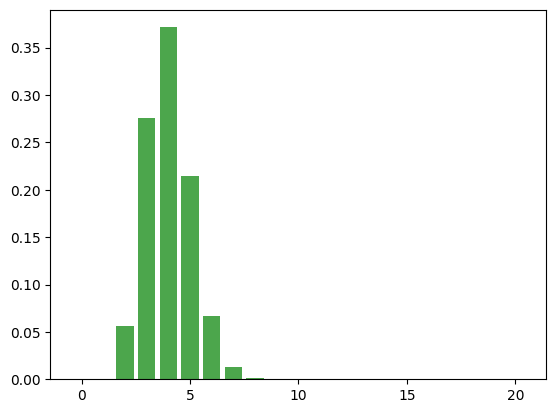

In [4]:
def PRD_sample(q, n=100000):
    state = 0
    n_test = 0
    n_states = [0] * (math.ceil(1 / q))
    for i in range(n):
        n_states[state] += 1
        if np.random.rand() < (state + 1) * q:
            state = 0
            n_test += 1
        else:
            state += 1
    return n_test / n, [n_states[i] / n for i in range(len(n_states))]

q = 0.0557
p, n_states = PRD_sample(q)
print(f'PRD_sample({q}) = {p}, n_states = {n_states}')
print(f'E[X] = {sum(prd_pn[i] * n_states[i] for i in range(len(n_states)))}')
print(f'sigma[X] = {math.sqrt(sum((prd_pn[i] ** 2) * n_states[i] for i in range(len(n_states))) - (sum(prd_pn[i] * n_states[i] for i in range(len(n_states)))) ** 2)}')

def PRD_sample_N(q, N, offset=100, n=10000):
    n_results = [0] * (N + 1)
    n_states = [0] * (math.ceil(1 / q))
    for i in range(n):
        state = 0
        n_test = 0
        for _ in range(offset):
            if np.random.rand() < (state + 1) * q:
                state = 0
            else:
                state += 1
        n_states[state] += 1
        for _ in range(N):
            if np.random.rand() < (state + 1) * q:
                state = 0
                n_test += 1
            else:
                state += 1
        n_results[n_test] += 1
    return [n_results[i] / n for i in range(len(n_results))], [n_states[i] / n for i in range(len(n_states))]

n_results, n_states = PRD_sample_N(q, N)
print(f'PRD_sample_N({q}, {N}) = {n_results}')
print(f'n_states = {n_states}')
print(f'E[X] = {sum(n_results[i] * i for i in range(len(n_results)))}')
print(f'sigma[X] = {math.sqrt(sum(n_results[i] * (i**2) for i in range(len(n_results))) - (sum(n_results[i] * i for i in range(len(n_results)))) ** 2)}')
plt.bar(np.arange(0, N + 1), n_results, color='green', alpha=0.7)